# Importing Data

In [93]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


In [94]:
#https://www.kaggle.com/datasets/santoshd3/bank-customers
#Churn prediction dataset
churnData = pd.read_csv('Churn Modeling.csv')
#Remove Row Number, customer_id, and surname as they will not impact churn
churnData = churnData.iloc[:,3:]
churnData = churnData.rename({'Exited':'Churn','HasCrCard':'HasCreditCard'},axis=1)
churnData.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [95]:
#print(churnRatios['Female'].value_counts()[1])
#print(churnRatios['Female'].nunique())
    

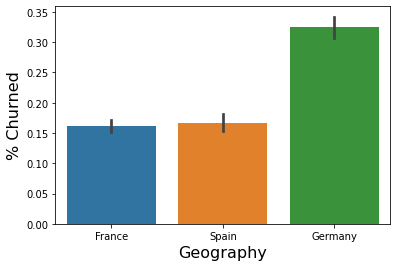

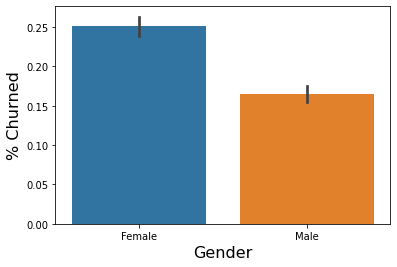

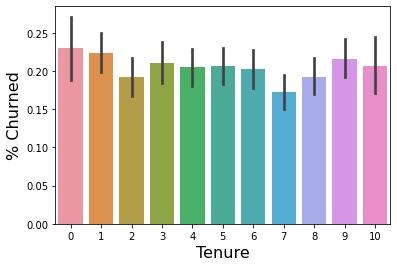

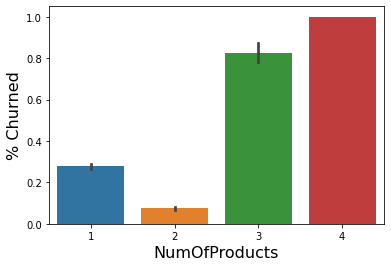

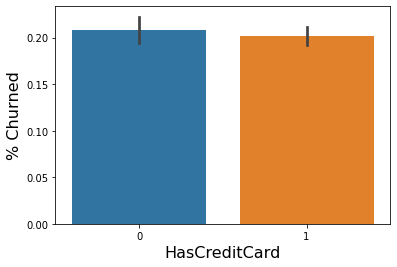

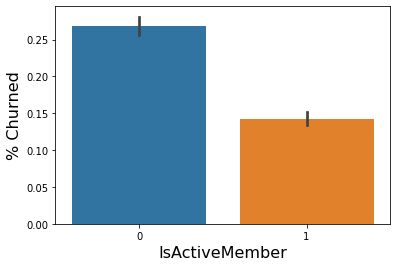

In [96]:
def RatioPlotCompare(data,factor,xticks=None):
    fig,ax=plt.subplots()
    plot=sns.barplot(data=data, x=factor, y='Churn')
    plt.xlabel(factor, fontsize=16);
    plt.ylabel('% Churned', fontsize=16)
    if(xticks!=None):
        plot.set_xticklabels(xticks)
        
churnGraphs = churnData.drop(['CreditScore','Balance','Age','EstimatedSalary'],axis=1)
for key in churnGraphs.keys()[:-1]:
    RatioPlotCompare(churnGraphs,key)

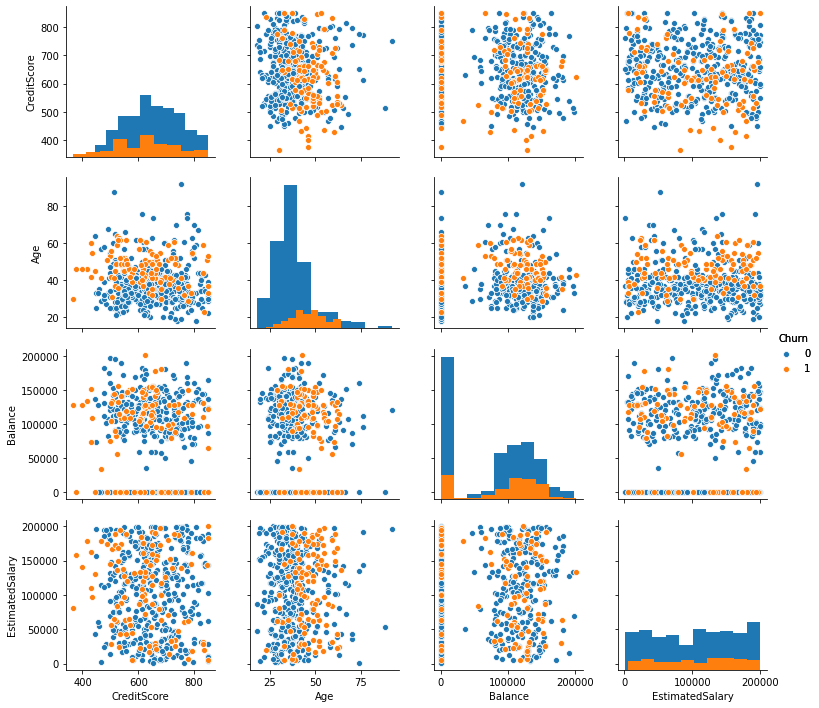

In [97]:
churnPair = sns.pairplot(churnData.sample(frac=0.05), vars=['CreditScore','Age','Balance','EstimatedSalary'], hue='Churn', kind='scatter', diag_kind='hist')
churnPair.add_legend()

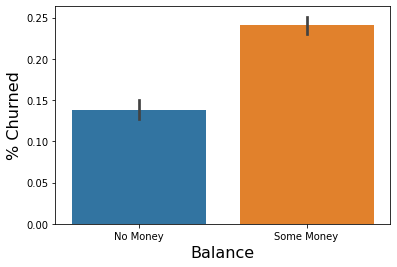

In [98]:
#Sets all Balance values to 0 or 1. 0 for people with no money, 1 otherwise
churnBalance = churnData.copy()
churnBalance['Balance'] = churnBalance['Balance'].where(churnData['Balance']==0.0,other=1.0)
churnBalance = churnBalance.astype({'Balance':'int32'})
RatioPlotCompare(churnBalance,'Balance',["No Money","Some Money"])

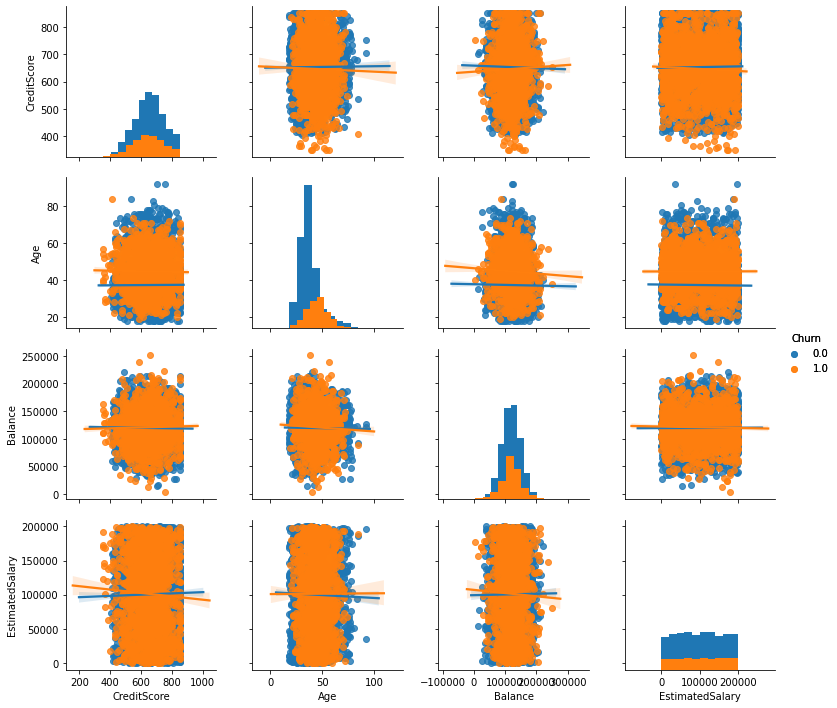

In [99]:
#Drop everything with no balance, then check for multicollinearty.
churnNewBalance = churnData.where(churnData['Balance']!=0.0)
churnNewBalance = churnNewBalance.dropna()
churnPair = sns.pairplot(churnNewBalance, vars=['CreditScore','Age','Balance','EstimatedSalary'], hue='Churn', kind='reg', diag_kind='hist')
churnPair.add_legend()

In [ ]:
#Features selected from Exploratory Analysis: IsGermany, Sex, Tenure, NumOfProducts, IsActiveMember, Age, HasBalance
#Extract only necessary features relating to churn.
churn = churnData[['Geography','Gender','Tenure','NumOfProducts','IsActiveMember','Age']]
#Convert Geography and Gender into multiple columns, encoding them as 0s and 1s. What this indicates is that every
#potential value for these variables will receive a column, with a 1 denoting whether a customer had that value
#originally, and a 0, the opposite. This was performed as Classifier Algorithms cannot interpret non numeric data
churn = pd.get_dummies(churnData, columns=['Geography','Gender'], sparse=False, drop_first=False).iloc[:,5:-1]
#ChurnBalance's Balance column only contains a 0 or a 1. 0 if no money, 1 if some
churn['Balance']=churnBalance['Balance']
churn[['Tenure','NumOfProducts','Age']]= churnData[['Tenure','NumOfProducts','Age']]
#Renaming columns for clarity.
churn = churn.rename({'Geography_Germany':'IsGermany','Gender_Female':'Female','Balance':'HasBalance'},axis=1)
#As only Germany indicated an impact on churn, France and Spain are uneccessary. We simply need to know whether a customer
#is german or not.
churn=churn.drop(['Geography_France','Geography_Spain',],axis=1)
churn=churn[['Age','IsActiveMember','IsGermany','Female','NumOfProducts','HasBalance','Tenure','Churn']]
churn.head()

,Age,IsActiveMember,IsGermany,Female,NumOfProducts,HasBalance,Tenure,Churn
0,42,1,0,1,1,0,2,1
1,41,1,0,1,1,1,1,0
2,42,0,0,1,3,1,8,1
3,39,0,0,1,2,0,1,0
4,43,1,0,1,1,1,2,0


In [ ]:
#FOR A GUIDE TO THE CODE, I USED THE CITATION LABLED "FEATURE SELECTION AND KNN CLASSIFICATION
#This code is a heavily modified version of that appearing in my Wine Project
#Create a dataframe to store the accuracies of each inidivudal model.
tenureAccuracies = pd.DataFrame(columns=['RandomForest','LogisticRegression','NaiveBayes','DecisionTree'])
#Determine the accuracy of each model for each tenure value.
for i in range(11):    
    accuracies = pd.DataFrame(columns=['RandomForest','LogisticRegression','NaiveBayes','DecisionTree'])
    #We are dropping the data not relevant to the current tenure we are testing
    tenureChurn = churn.where(churn['Tenure']!=i)
    tenureChurn = tenureChurn.dropna()
    #y is our prediction value, in this case, Churn
    y=tenureChurn['Churn']
    X=tenureChurn.iloc[:,:-2]
    #We will test each potential predictor model 40 times per tenure, and average their accuracy for each bracket.
    for i in range(40):
        #Split data randomly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        accuracyList = {}
        #Ascertain accuracy of each of the 4 models.
        clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
        accuracyList['RandomForest']=pd.Series(clf.score(X_test,y_test))
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        accuracyList['LogisticRegression']=pd.Series(clf.score(X_test,y_test))
        clf = GaussianNB().fit(X_train,y_train)
        accuracyList['NaiveBayes']=pd.Series(clf.score(X_test,y_test))
        clf = DecisionTreeClassifier().fit(X_train, y_train)
        accuracyList['DecisionTree']=pd.Series(clf.score(X_test,y_test))
        accuracyList = pd.DataFrame.from_dict(accuracyList)
        accuracies=pd.concat([accuracies,accuracyList])
    #Average accuracy, and store
    accuracies.reset_index()
    accuracies = accuracies.sum()/40
    accuracies=pd.DataFrame(accuracies).T
    tenureAccuracies=pd.concat([tenureAccuracies,accuracies])
tenureAccuracies=tenureAccuracies.reset_index().drop('index',axis=1)
tenureAccuracies

In [ ]:
meanAccs = tenureAccuracies.mean()
meanAccs

In [ ]:
accList = pd.Series(data=np.zeros(29,),index=range(3,60,2))
y=churn['Churn']
X=churn.iloc[:,:-1]
#Run each neighbor 9 times to determine its rough accuracy
for i in range(9):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #Only run odd number neighbors, even numbers create ties.
    for x in range(3,60,2):
        classifier = KNeighborsClassifier(n_neighbors=x)
        classifier = classifier.fit(X_train, y_train)
        accList[x]+=classifier.score(X_test, y_test)
accList/=9
accList

In [ ]:
ma = max(accList)
print("Max attained accuracy: " + str(ma))


In [ ]:
accs = pd.DataFrame(accList)
accs=accs.rename({0:'Accuracies'},axis=1)
sns.lineplot(data=accs,markers=True)

In [ ]:
accList = list()
for i in range(11):
    acc = 0
    tenureChurn = churn.where(churn['Tenure']!=i)
    tenureChurn = tenureChurn.dropna()
    y=tenureChurn['Churn']
    X=tenureChurn.iloc[:,:-2]
    for i in range(40):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        scaler.fit(X_test)
        X_test = scaler.transform(X_test)
        clf = KNeighborsClassifier(n_neighbors=17).fit(X_train, y_train)
        acc+=clf.score(X_test,y_test)
    acc/=40
    accList.append(acc)
accList

In [ ]:
kNN_Mean = sum(accList)/len(accList)

In [ ]:
newSeries = pd.Series(data=[kNN_Mean],index=['KNeighbors'])
newSeries

In [ ]:
ClassifierAccuracies = pd.concat([meanAccs,newSeries])
ClassifierAccuracies

In [ ]:
#
# BORROWED WINE PROJECT CODE. I WAS THE CREATOR OF THIS CODE FOR THE ORIGINAL PROJECT. THE ORIGINAL CITATION IS THE CITATION LABLED (PERRY)
#
import random
def determineFeatureImportance(cData, Kn, include='all', seed=random.randrange(0,9999),testSize=0.05, trials=15, color='silver'):
    y = cData['Churn']
    if(include=='all'):
        include = cData.keys()[:-2].values.copy()
        
    X=cData[include]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=seed)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test,columns=include)
    #Such code can be swapped out for any classifier!
    classifier = KNeighborsClassifier(n_neighbors=Kn)
    classifier = classifier.fit(X_train, y_train)
    primaryScore = classifier.score(X_test, y_test)
    featureImportance = pd.DataFrame({include[i]: 0 for i in range(len(include))},index=[0])
    for i in range(trials):
        for key in include:
            permute_X = X_test.copy()
            permute_X[key] = np.random.permutation(X_test[key])
            featureImportance[key] += primaryScore - classifier.score(permute_X,y_test)
    for key in include:
        featureImportance[key]/=trials
    plt.figure(figsize=(8,5))
    bar = plt.bar(x=include,height=featureImportance.iloc[0].values,color=color,width=.4)
    plt.xticks(range(len(include)),include,rotation='vertical',fontsize=16)
    plt.title("Feature Importance of Model", fontsize=16)
    plt.xlabel("FEATURES")
    plt.ylabel("IMPORTANCE")
    plt.show()

In [ ]:
determineFeatureImportance(churn,17)
#churn.head()